In [1]:
using LinearAlgebra
using PlotlyJS

include("hubbard_core.jl")

no_particles_from_state (generic function with 1 method)

In [3]:
t = 1
U = 1

const N = 2
const states = reshape(Iterators.product([[0,1] for _ in 1:2N]...) .|> collect, (1, 2^(2N)))
const next = [collect(2:N); 1]

2-element Vector{Int64}:
 2
 1

## Zależność od potencjału chemicznego w T=0K

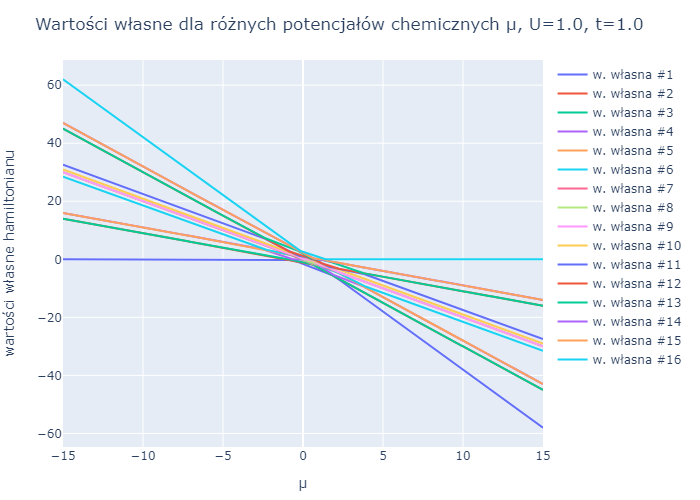

In [14]:
pot_max = 15
pot_step = 0.05
potentials = collect(-pot_max:pot_step:pot_max)
data = [eigen(get_hamiltonian(states, U, t, pot, next, N)) for pot in potentials]
eigs_mat_orig = reduce(hcat,[real(d.values) for d in data])'
eigvecs = [real(d.vectors) for d in data]
eigs_mat = [eigs_mat_orig[:,i] for i in 1:size(eigs_mat_orig,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [ ]:
[real(d.vectors)[:,1] for d in data][523]

Wybieramy stany o najmniejszej energii (dolna krawędź powyższego wykresu):

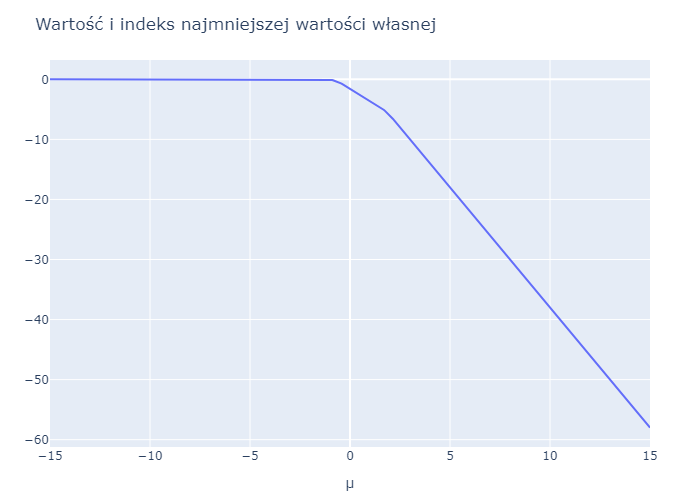

In [15]:
ground_energies = [findmin(eigs_mat_orig[i,:]) for i in 1:size(potentials,1)]
ground_energies = [g[1] for g in ground_energies]
# all_states = [real(eigvecs(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials]
ground_states = [real(d.vectors)[:,1] for d in data][1]

layout = Layout(
    title="Wartość i indeks najmniejszej wartości własnej",
    xaxis_title="μ",
)
plot(scatter(x=potentials, y=[g for g in ground_energies], name="Wartość"), layout)

Wartości własne zwizualizowane:

In [ ]:
# plot([scatter(x=1:16, y=real(data[1].vectors)[1,i]) for i in 1:16])
# plot([scatter(x=1:16, y=real(eigvecs)[1,i]) for i in 1:16])
eigval_idx = 1
eigenvals_sorted = [[eigvecs[pot][:,eigval_idx][eigv] for pot in 1:601] for eigv in 1:16]
plot([scatter(x=potentials, y=tt, name=reduce(*, string.(statename))) for (tt, statename) in zip(eigenvals_sorted, states)])


Średnia ilość cząstek w stanie, w zależności od potencjału chemicznego:

In [ ]:
avg_no_particles = [[no_particles_from_state(state, N) for state in 
    [states_row[:, i] for states_row in eigvecs]] for i in 1:2^(2N)]

layout = Layout(
    title="Średnia ilość cząstek w funkcji potencjału chemicznego μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="Średnia ilość cząstek",
)
plot([scatter(x=potentials, y=avg_no_particles[1])], layout)

## Zależność temperaturowa

In [4]:
U = 1.0
t = 1.0
k = 1.0

function compute_thermodynamic_quantities(chem_pot, temperature, U, t, next, states)
    N = Int(length(states[1])//2)
    H_matrix = get_hamiltonian(states, U, t, chem_pot, next, N)
    diagonalized = eigen(H_matrix)
    energies = diagonalized.values
    H_states = diagonalized.vectors
    exp_vec = exp.(-real(energies) / (k*temperature))
    stat_sum = reduce(+, exp_vec)
    avg_particles = [no_particles_from_state(H_states[:, i], N) for i in 1:(2N)^2]
    
    densities = exp_vec ./ stat_sum
    avg_particles_temp = reduce(+, densities .* avg_particles)
    entropy = -k * reduce(+, [abs(p)*log(abs(p)) for p in densities])
    grand_potential = -k*temperature*log(stat_sum)
    return densities, avg_particles_temp, entropy, grand_potential
end

chem_potentials = -7.5:0.05:7.5
temp_range = round.(10.0.^(range(-1.5,stop=1.5,length=5)), digits=3)

thermodynamics = [[compute_thermodynamic_quantities(chem_pot, temperature, U, t, next, states)
        for chem_pot in chem_potentials] for temperature in temp_range]

avg_n = [[thermodynamics[j][i][2] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
entropy_vals = [[thermodynamics[j][i][3] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]
grand_pots = [[thermodynamics[j][i][4] for i in 1:length(chem_potentials)] for j in 1:length(temp_range)]

helmholtz_vals = [[grand_pot + chem_pot*avg_no for (grand_pot, chem_pot, avg_no) in zip(grand_pot_rows, chem_potentials, avg_no_rows)] 
    for (grand_pot_rows, temp, avg_no_rows) in zip(grand_pots, temp_range, avg_n)]

U_vals = [[helm + entr*temp for (pot, helm, entr) in zip(chem_potentials, helmholtz_vals_rows, entr_rows)]
     for (temp, helmholtz_vals_rows, entr_rows) in zip(temp_range, helmholtz_vals, entropy_vals)]

5-element Vector{Vector{Float64}}:
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [-2.7666620142038874e-16, -3.663944945562176e-16, -4.852234387572382e-16, -6.425909477831548e-16, -8.509958365375449e-16, -1.1269905315388796e-15, -1.492495736930994e-15, -1.9765414725494984e-15, -2.6175727648922636e-15, -3.46650311904016e-15  …  1.999999999998087, 1.9999999999985603, 1.999999999998917, 1.999999999999176, 1.9999999999993787, 1.9999999999995286, 1.999999999999653, 1.999999999999729, 1.9999999999997933, 1.9999999999998463]
 [-0.002593186106510721, -0.0027257784088741306, -0.002865130769222606, -0.0030115857932325775, -0.003165503235394787, -0.0033272608348306476, -0.0034972551894643863, -0.003675902670055145, -0.00386364037562395, -0.004060927131837061  …  1.974603812335826, 1.9758313180326275, 1.9770000025360415, 1.9781126364636228, 1.9791718644650287, 1.9801802105190536, 1.9811400830494683, 1.9820537798616753, 1.9829234929023838, 

In [5]:
y_vals = avg_n

layout = Layout(
    title="Średnia ilość cząstek od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

data: [
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

In [6]:
y_vals = entropy_vals

layout = Layout(
    title="Entropia od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

data: [
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y",
  "scatter with fields name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

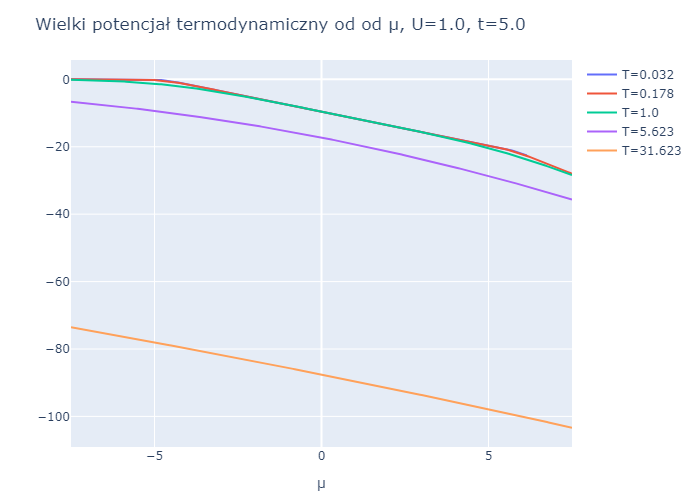

In [26]:
y_vals = grand_pots

layout = Layout(
    title="Wielki potencjał termodynamiczny od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

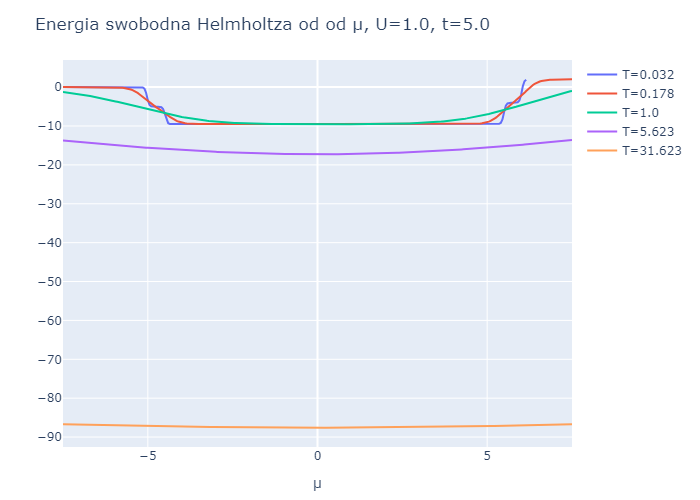

In [27]:
y_vals = helmholtz_vals

layout = Layout(
    title="Energia swobodna Helmholtza od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

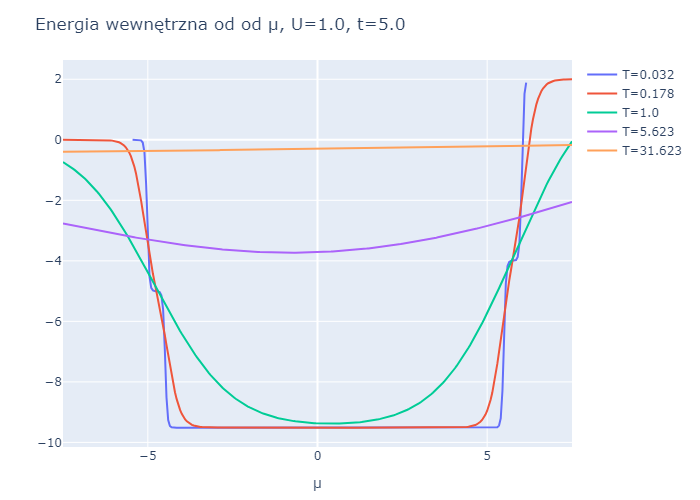

In [28]:
y_vals = U_vals

layout = Layout(
    title="Energia wewnętrzna od od μ, U=$U, t=$t",
    xaxis_title="μ",
    yaxis_title="",
)
plot([scatter(x=chem_potentials, y=yval, name="T=$t") for (yval, t) in zip(y_vals, temp_range)], layout)

Z Lanczosem:

In [8]:
using KrylovKit

In [30]:
A = rand(10, 10) 
A = A' * A
test1 = eigsolve(A, 3, :SR)

([0.004203974891673687, 0.14596069804783285, 0.29609762006656065, 0.4110721159184519, 0.4583817789613971, 0.9432979772934514, 1.20549184821981, 1.4542522488735268, 1.8640880837980438, 27.775405362149], [[-0.307735477258733, 0.13215213708342569, -0.07164145474193807, -0.48705514953037565, 0.13598141030667993, 0.5048683160559716, 0.48135149384873316, -0.3528862254663012, -0.1187731132274985, 0.04197035016326554], [0.08308461938279534, -0.25555440923418354, 0.47839749824253125, 0.38981900098095656, -0.4397309745754611, 0.41000247825191466, 0.06003650334094737, -0.2566544613541218, -0.23021087466226678, -0.2510529164131246], [0.3478378651791758, -0.04111062429333781, -0.7342048850000089, 0.2726384160461395, -0.18755016671951447, 0.16929253783719075, 0.336588162318306, 0.006984721687162562, 0.13328069194961167, -0.2626615092766324], [0.3551503894264596, 0.12770935006297476, 0.01986651898121146, 0.2278706223130837, 0.43120199644386303, -0.23234850880096522, -0.02511209041520296, -0.742337524

In [31]:
test1[1]

10-element Vector{Float64}:
  0.004203974891673687
  0.14596069804783285
  0.29609762006656065
  0.4110721159184519
  0.4583817789613971
  0.9432979772934514
  1.20549184821981
  1.4542522488735268
  1.8640880837980438
 27.775405362149